In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tg
import tg.obj as obj
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [4]:
with open('susan.obj') as f:
    lines = f.readlines()
triangles = tf.constant(obj.load(lines), dtype=tf.float32)
colors = tf.random.uniform(triangles.shape, dtype=tf.float32)

triangles = -triangles * 256

min = tf.reduce_min(tf.reduce_min(triangles, -2), -2)
max = tf.reduce_max(tf.reduce_max(triangles, -2), -2)
size = max - min

triangles = triangles - min

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-05 15:10:36.278375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-05 15:10:36.278496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
dtype = tf.float64

In [6]:
size_ = tf.cast(size, dtype)
def shader(xyz):
    return (xyz / size_) * (1 - (tf.expand_dims(xyz[:, :, :, 2], -1) / size_))

In [7]:
width, height = int(size[0].numpy()), int(size[1].numpy())

In [8]:
with tf.device("/CPU:0"):
    color = tg.render(triangles, colors, width, height, -np.inf, np.inf, shader, dtype)

Instructions for updating:
Use fn_output_signature instead


2022-03-05 15:10:36.990553: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-05 15:10:36.991108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


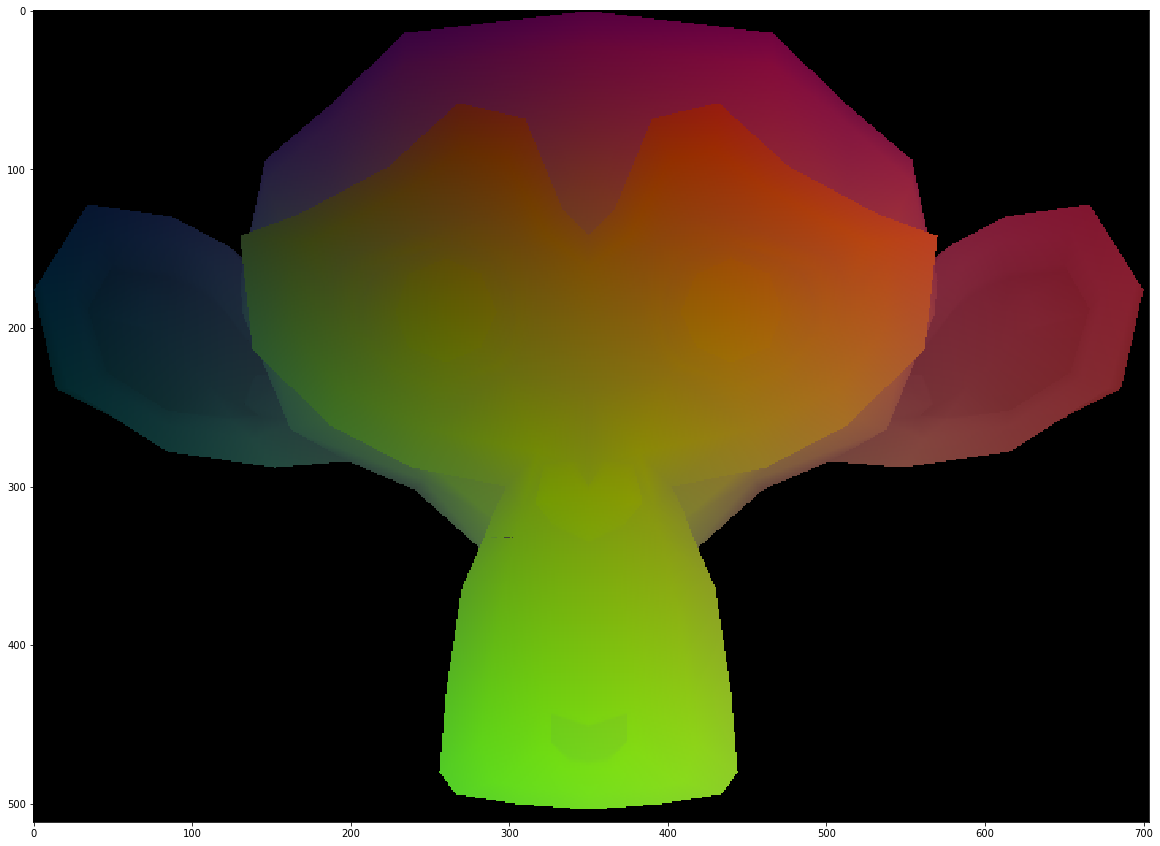

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(
    # tf.transpose(depth),
    tf.transpose(color, (1, 0, 2)),
    interpolation='nearest'
)
pass